# USDA Soil Texture Plot + Your Samples

1. Plots **USDA soil texture classes** (using `mpltern`).
2. Reads your sample data from a **CSV** (and optionally **XLSX** later).
3. Plots each sample on the ternary diagram.
4. Computes and plots the **centroid** (the mean Sand/Silt/Clay composition).
5. Prints the **USDA texture class** for each sample and for the centroid.

> **Important:** Each sample must have Sand + Silt + Clay ≈ 100.

If you’re missing any of them:

```bash
pip install mpltern pandas openpyxl
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib._cm import _Set3_data
from matplotlib.path import Path
from mpltern.datasets import soil_texture_classes

## Plot USDA soil texture classes

mpltern: https://mpltern.readthedocs.io/en/develop/gallery/miscellaneous/soil_texture.html

In [2]:
def calculate_polygon_centroid(vertices: np.ndarray) -> np.ndarray:
    """
    Calculate the centroid of a 2D polygon.

    This is used for labeling the USDA class polygons.
    https://en.wikipedia.org/wiki/Centroid#Of_a_polygon

    Parameters
    ----------
    vertices : (n, 2) np.ndarray
        Polygon vertices in 2D (x, y).

    Returns
    -------
    centroid : (2, ) np.ndarray
        Centroid of the polygon (x, y).
    """
    roll0 = np.roll(vertices, 0, axis=0)
    roll1 = np.roll(vertices, -1, axis=0)
    cross = np.cross(roll0, roll1)
    area = 0.5 * np.sum(cross)
    return np.sum((roll0 + roll1) * cross[:, None], axis=0) / (6.0 * area)


def plot_soil_texture_classes(ax):
    """
    Plot USDA soil texture classes and return polygon Paths.

    Returns
    -------
    dict
        Mapping of {class_name: matplotlib.path.Path} in *projected* (x, y) data coordinates.
    """
    classes = soil_texture_classes
    class_paths = {}

    for (key, value), color in zip(classes.items(), _Set3_data):
        tn0, tn1, tn2 = np.array(value).T
        patch = ax.fill(tn0, tn1, tn2, ec='k', fc=color, alpha=0.6, zorder=2.1)
        # patch = ax.fill(tn0, tn1, tn2, ec='k', fc="white", alpha=0.6, zorder=2.1)

        # Label placement: centroid of the drawn polygon in 2D
        poly_xy = patch[0].get_xy()
        centroid_xy = calculate_polygon_centroid(poly_xy)

        label = key[::-1].replace(' ', '\n', 1)[::-1].capitalize()
        ax.text(centroid_xy[0], centroid_xy[1], label, ha='center', va='center', transform=ax.transData, alpha=1.0, zorder=2.2)

        # Save a Path for classification
        class_paths[key] = Path(poly_xy)

    # Axis formatting (same as original)
    ax.taxis.set_major_locator(MultipleLocator(10.0))
    ax.laxis.set_major_locator(MultipleLocator(10.0))
    ax.raxis.set_major_locator(MultipleLocator(10.0))

    ax.taxis.set_minor_locator(AutoMinorLocator(2))
    ax.laxis.set_minor_locator(AutoMinorLocator(2))
    ax.raxis.set_minor_locator(AutoMinorLocator(2))

    ax.grid(which='both')
    ax.taxis.set_ticks_position('tick2')
    ax.laxis.set_ticks_position('tick2')
    ax.raxis.set_ticks_position('tick2')

    # Labeling consistent with common USDA triangle convention
    ax.set_tlabel('Clay (%)')
    ax.set_llabel('Sand (%)')
    ax.set_rlabel('Silt (%)')

    return class_paths


## Normalize your samples so Sand + Silt + Clay = 100

Field / lab data often has rounding or may be recorded as fractions.
This function makes your samples safe to plot and classify.


In [3]:
def normalize_to_100(sand, silt, clay):
    """
    Normalize Sand/Silt/Clay so each row sums to 100.

    Accepts lists, numpy arrays, or pandas Series.

    Parameters
    ----------
    sand, silt, clay : array-like
        Percent values (or any proportional values). Each row/sample will be scaled.

    Returns
    -------
    sand_n, silt_n, clay_n : np.ndarray
        Normalized arrays (each row sums to 100).
    """
    sand = np.asarray(sand, dtype=float)
    silt = np.asarray(silt, dtype=float)
    clay = np.asarray(clay, dtype=float)
    total = sand + silt + clay
    return sand/total*100.0, silt/total*100.0, clay/total*100.0


## Classify a sample into a USDA texture class

Classify by checking which USDA polygon contains your sample point.


In [4]:
def ternary_point_to_xy(ax, clay, sand, silt):
    """
    Convert a ternary point (Clay, Sand, Silt) to projected (x, y).
    """
    coll = ax.scatter([clay], [sand], [silt], s=0.1, alpha=0.0)
    xy = coll.get_offsets()[0]
    coll.remove()
    return xy


def classify_sample(ax, class_paths, sand, silt, clay):
    """
    Return the USDA texture class name for one sample.

    Parameters
    ----------
    sand, silt, clay : float
        Percent composition. Should sum to 100 (approximately).

    Returns
    -------
    str
        Class name (e.g., 'sandy loam'). If no polygon matches, returns 'unclassified'.
    """
    xy = ternary_point_to_xy(ax, clay, sand, silt)
    for class_name, path in class_paths.items():
        if path.contains_point(xy):
            return class_name
    return 'unclassified'


## Plot samples + centroid (mean composition)


In [5]:
def plot_samples_and_centroid(ax, sand, silt, clay, sample_labels=None, label='Samples'):
    """
    Plot samples and their centroid (mean composition) on the ternary diagram.

    Parameters
    ----------
    sand, silt, clay : array-like
        Sample compositions.
    sample_labels : list[str] or None
        Optional labels for each sample (e.g., SampleName).
    label : str
        Legend label for the sample cloud.

    Returns
    -------
    tuple
        (sand_c, silt_c, clay_c) centroid values.
    """
    sand, silt, clay = normalize_to_100(sand, silt, clay)

    # Plot points (note: mpltern expects (t, l, r) -> here (Clay, Sand, Silt))
    ax.scatter(clay, sand, silt, s=25, edgecolors='k', linewidths=0.7, zorder=2.4, label=label)
    
    # Centroid (mean)
    sand_c = float(np.mean(sand))
    silt_c = float(np.mean(silt))
    clay_c = float(np.mean(clay))
    # Optionally label each sample near its point
    show_labels = True
    if show_labels:
        # ax.text(clay_c, sand_c, silt_c,
        #         f"Mean: {sand_c:.1f}% sand, {silt_c:.1f}% silt, {clay_c:.1f}% clay",
        #         fontsize=9, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.6, edgecolor="k", linewidth=0.6), zorder=3.0)
        if sample_labels is not None:
            for si, (cl, sa, sl, name) in enumerate(zip(clay, sand, silt, sample_labels)):
                ax.text(cl, sa, sl, str(name), fontsize=7, ha='left', va='bottom', bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=1.0, edgecolor="k", linewidth=0.6), zorder=2.3)


    ax.scatter([clay_c], [sand_c], [silt_c], s=100, marker='*', edgecolors='k', linewidths=1.2,
               zorder=2.9, label='Centroid (mean)')

    return sand_c, silt_c, clay_c


## Read your data file (XLSX or CSV (needs headers))

## Run the full workflow

1. Read `my_soils.csv`
2. Plot USDA classes
3. Plot samples + centroid
4. Print classification for each sample and for the centroid


/tmp/ipykernel_4503/2916457296.py:20: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(roll0, roll1)



--------------------------------------------------
------------- Sample classifications -------------
--------------------------------------------------
1.1: Sand=46.2, Silt=32.3, Clay=21.5 -> loam
1.2: Sand=55.6, Silt=11.1, Clay=33.3 -> sandy clay loam
1.3: Sand=68.4, Silt=21.1, Clay=10.5 -> sandy loam
1.4: Sand=83.3, Silt=11.7, Clay=5.0 -> loamy sand
1.5: Sand=87.5, Silt=7.5, Clay=5.0 -> sand
1.1: Sand=60.0, Silt=30.0, Clay=10.0 -> sandy loam
1.2: Sand=70.0, Silt=20.0, Clay=10.0 -> sandy loam
1.3: Sand=75.0, Silt=15.0, Clay=10.0 -> sandy loam
1.4: Sand=70.0, Silt=15.0, Clay=15.0 -> sandy loam
1.5: Sand=65.0, Silt=20.0, Clay=15.0 -> sandy loam

--------------------------------------------------
--------- Centroid (mean) classification ---------
--------------------------------------------------
Centroid: Sand=68.1, Silt=18.4, Clay=13.5 -> sandy loam


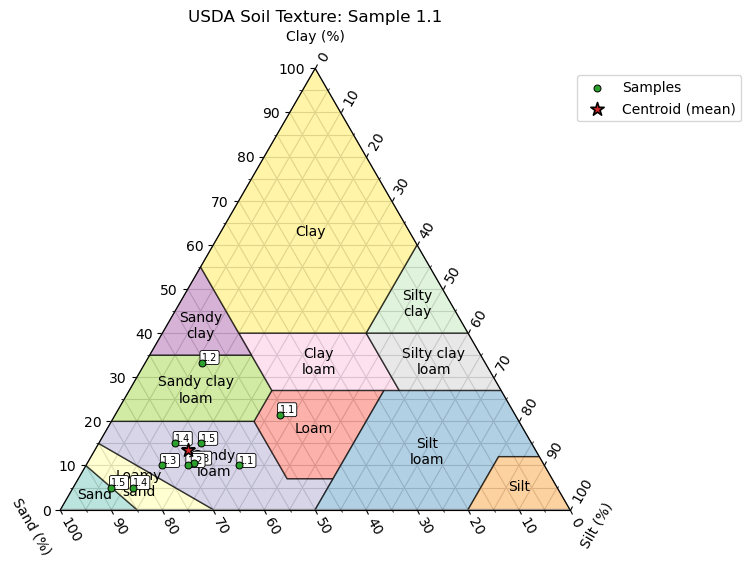

In [6]:
def read_soil_file(path):
    """
    Read a soil data file (.csv or .xlsx) into a DataFrame.
    """
    path = str(path)
    if path.lower().endswith('.csv'):
        return pd.read_csv(path)
    if path.lower().endswith(('.xlsx', '.xls')):
        return pd.read_excel(path)
    raise ValueError('Unsupported file type. Use .csv or .xlsx')


def main(data_path='my_soils.xlsx',title=None):
    # Read your samples
    df = read_soil_file(data_path)
    full_title = f"USDA Soil Texture: {title}"

    # Basic checks
    required = {'Sand', 'Silt', 'Clay'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Need Sand, Silt, Clay.")

    # Normalize
    sand, silt, clay = normalize_to_100(df['Sand'], df['Silt'], df['Clay'])

    # Create plot
    plt.figure(figsize=(8, 7))
    ax = plt.subplot(projection='ternary', ternary_sum=100.0)

    # USDA polygons + Paths for classification
    class_paths = plot_soil_texture_classes(ax)

    # Plot samples and centroid
    labels = df['SampleName'] if 'SampleName' in df.columns else None
    sand_c, silt_c, clay_c = plot_samples_and_centroid(ax, sand, silt, clay, sample_labels=labels)

    # Print classification per sample
    print(f'\n{"-"*50}\n------------- Sample classifications -------------\n{"-"*50}')
    for i, row in df.iterrows():
        s, si, c = float(row['Sand']), float(row['Silt']), float(row['Clay'])
        s_n, si_n, c_n = normalize_to_100([s],[si],[c])
        cls = classify_sample(ax, class_paths, s_n[0], si_n[0], c_n[0])
        name = row['SampleName'] if 'SampleName' in df.columns else f'Sample {i+1}'
        print(f"{name}: Sand={s_n[0]:.1f}, Silt={si_n[0]:.1f}, Clay={c_n[0]:.1f} -> {cls}")

    # Classify centroid
    centroid_class = classify_sample(ax, class_paths, sand_c, silt_c, clay_c)
    print(f'\n{"-"*50}\n--------- Centroid (mean) classification ---------\n{"-"*50}')
    print(f"Centroid: Sand={sand_c:.1f}, Silt={silt_c:.1f}, Clay={clay_c:.1f} -> {centroid_class}")

    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
    plt.title(full_title)
    plt.tight_layout()
    plt.show()


# Run it!!!!
title = "Sample 1.1"
FILE_PATH = f'{title}.xlsx'
main(FILE_PATH, title)
